#영화리뷰 감정분석

---

##목차
- 구글 드라이브 임포트
- Mecab 사용을 위한 사전 설정
- 필요한 라이브러리 임포트
- 데이터 확인
- 데이터 준비
- 단어를 인덱스로 리턴해주는 index_to_word 생성
- 데이터 가공
- 모델 생성 및 학습
- 가장 높은 결과를 가지는 모델 파라미터 재설정
- 학습 결과 시각화
- 학습괸 임베딩 레이어 분석
- 실제로 리뷰 문장을 분석해보자
- 한국어 Word2Vec 임베딩
- 위에 만든 임베딩으로 모델 학습
- 결과 확인
- 학습 결과 시각화
- 실제로 리뷰 문장을 분석해보자
- 마무리

##구글 드라이브 임포트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

##Mecab 사용을 위한 사전 설정

In [3]:
from IPython.display import clear_output
from time import sleep
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip3 install JPype1
!pip3 install konlpy
sleep(3)
clear_output()

In [4]:
!pip3 install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!echo "$JAVA_HOME"

In [6]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh) 
!pip3 install /tmp/mecab-python-0.996
sleep(2)
clear_output()

---

##필요한 라이브러리 임포트

In [84]:
import os
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

---

##데이터 확인

In [7]:
train_df = pd.read_table('/content/drive/MyDrive/pic/ex/ratings_train.txt')
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
train_df.shape

(150000, 3)

In [9]:
test_df = pd.read_table('/content/drive/MyDrive/pic/ex/ratings_test.txt')
test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [10]:
test_df.shape

(50000, 3)

---

##데이터 준비

데이터 준비 과정에서는 mecab을 사용한 토크나이저와 불용어 처리와 word_to_index를 생성해보았다.

In [11]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [12]:
def load_df(train_df, test_df, num_words=10000):
    train_df.drop_duplicates(subset=['document'], inplace=True)
    train_df = train_df.dropna(how = 'any') 
    test_df.drop_duplicates(subset=['document'], inplace=True)
    test_df = test_df.dropna(how = 'any') 

    X_train = []
    for sentence in train_df['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_df['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_df['label'])), X_test, np.array(list(test_df['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_df(train_df, test_df)

---

##단어를 인덱스로 리턴해주는 index_to_word 생성

index_to_word를 만들고 단어를 입력하면 인덱스 값을 리턴해주는 함수를 정의

In [13]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [14]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [15]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


---

##데이터 가공

패딩 추가 및 모델 생성전 데이터 가공

In [16]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)

In [17]:
print(X_train.shape)

(146182, 41)


In [18]:
print(X_test.shape)

(49157, 41)


In [19]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(20000, 41)
(20000,)
(126182, 41)
(126182,)


---

##모델 생성 및 학습

vocab_size, word_vector_dim은 통일 시키고 모델 생성

In [64]:
vocab_size = 10000
word_vector_dim = 300

###Conv1D 모델

In [22]:
d_model = keras.Sequential(name="d_model")
d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
d_model.add(keras.layers.Conv1D(256, 7, activation='relu'))
d_model.add(keras.layers.MaxPooling1D(5))
d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
d_model.add(keras.layers.GlobalMaxPooling1D())
d_model.add(keras.layers.Dense(8, activation='relu'))
d_model.add(keras.layers.Dense(1, activation='sigmoid'))

d_model.summary()

Model: "d_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3000000   
                                                                 
 conv1d (Conv1D)             (None, None, 256)         537856    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 256)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          114752    
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 520 

###GlobalMaxPooling1D 모델

In [23]:
g_model = keras.Sequential(name="g_model")
g_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
g_model.add(keras.layers.GlobalMaxPooling1D())
g_model.add(keras.layers.Dense(8, activation='relu'))
g_model.add(keras.layers.Dense(1, activation='sigmoid'))

g_model.summary()

Model: "g_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         3000000   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 2408      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


###LSTM 모델

In [24]:
inputs = keras.Input(shape = (None,))

x = keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)
x = keras.layers.LSTM(8, dropout = 0.7)(x)
x = keras.layers.Dense(8, activation='relu')(x)
pred = keras.layers.Dense(1, activation='sigmoid')(x)

l_model = keras.Model(name = 'l_model', inputs = inputs, outputs = pred)

l_model.summary()

Model: "l_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 300)         3000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 9888      
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_list = ['d_model', 'g_model', 'l_model']
print(model_list)

['d_model', 'g_model', 'l_model']


In [26]:
model_list2 = {}

for i in model_list:
  if i == "d_model":
      model = d_model
  elif i == "g_model":
      model = g_model
  else:
      model = l_model
    
  print("{} 모델학습 ...".format(i))
  model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

  hist = model.fit(partial_x_train, partial_y_train, epochs = 20, batch_size = 256, validation_data=(x_val, y_val), verbose=1)
  
  print("{} 모델평가 ...".format(i))
  results = model.evaluate(X_test,  y_test, verbose=2)
  model_list2[i] = results

d_model 모델학습 ...
Epoch 1/20
493/493 [==============================] - 18s 12ms/step - loss: 0.3998 - accuracy: 0.8068 - val_loss: 0.3261 - val_accuracy: 0.8591
Epoch 2/20
493/493 [==============================] - 6s 11ms/step - loss: 0.2671 - accuracy: 0.8893 - val_loss: 0.3297 - val_accuracy: 0.8587
Epoch 3/20
493/493 [==============================] - 6s 11ms/step - loss: 0.1751 - accuracy: 0.9325 - val_loss: 0.3710 - val_accuracy: 0.8598
Epoch 4/20
493/493 [==============================] - 6s 11ms/step - loss: 0.1010 - accuracy: 0.9630 - val_loss: 0.4997 - val_accuracy: 0.8536
Epoch 5/20
493/493 [==============================] - 6s 11ms/step - loss: 0.0603 - accuracy: 0.9788 - val_loss: 0.6182 - val_accuracy: 0.8469
Epoch 6/20
493/493 [==============================] - 6s 11ms/step - loss: 0.0468 - accuracy: 0.9831 - val_loss: 0.7071 - val_accuracy: 0.8472
Epoch 7/20
493/493 [==============================] - 6s 11ms/step - loss: 0.0363 - accuracy: 0.9871 - val_loss: 0.7741 - va

In [27]:
print(model_list2)

{'d_model': [1.3256791830062866, 0.8394531607627869], 'g_model': [1.0086811780929565, 0.8335130214691162], 'l_model': [0.3802279531955719, 0.84799724817276]}


---

##가장 높은 결과를 가지는 모델 파라미터 재설정

LSTM모델이 가장 성능이 좋았으므로 파라미터를 재 설정하여 다시 학습

우선 위의 학습을 보면 val_loss값이 내려가다가 다시 치솟고 있다.

이는 과적합을 의미한다고 볼 수 있다.

따라서 이번 모델은 LSTM의 차원과 dropout을 사용하여 모델을 정의함

이래도 loss값이 치솟을 경우를 대비하여 callback 정의

In [71]:
word_vector_dim = 1000

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(128, dropout=0.7))
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 1000)        10000000  
                                                                 
 lstm_8 (LSTM)               (None, 128)               578048    
                                                                 
 dense_16 (Dense)            (None, 8)                 1032      
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 10,579,089
Trainable params: 10,579,089
Non-trainable params: 0
_________________________________________________________________


In [66]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [72]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
              
hist = model2.fit(partial_x_train, partial_y_train, epochs = 20, batch_size = 128, validation_data=(x_val, y_val), verbose=1,
                 callbacks=[early_stopping, model_check])

Epoch 1/20
982/986 [============================>.] - ETA: 0s - loss: 0.4713 - accuracy: 0.7560
Epoch 1: val_accuracy did not improve from 0.86455
986/986 [==============================] - 15s 14ms/step - loss: 0.4707 - accuracy: 0.7565 - val_loss: 0.3411 - val_accuracy: 0.8497
Epoch 2/20
983/986 [============================>.] - ETA: 0s - loss: 0.3286 - accuracy: 0.8589
Epoch 2: val_accuracy did not improve from 0.86455
986/986 [==============================] - 13s 13ms/step - loss: 0.3284 - accuracy: 0.8590 - val_loss: 0.3261 - val_accuracy: 0.8596
Epoch 3/20
983/986 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.8755
Epoch 3: val_accuracy did not improve from 0.86455
986/986 [==============================] - 12s 12ms/step - loss: 0.2916 - accuracy: 0.8756 - val_loss: 0.3197 - val_accuracy: 0.8612
Epoch 4/20
984/986 [============================>.] - ETA: 0s - loss: 0.2666 - accuracy: 0.8871
Epoch 4: val_accuracy did not improve from 0.86455
986/986 [====

###결과

In [73]:
num2 = model2.evaluate(X_test,  y_test, verbose=2)
print(num2)

1537/1537 - 4s - loss: 0.3525 - accuracy: 0.8576 - 4s/epoch - 3ms/step
[0.35249704122543335, 0.8575787544250488]


---

##학습 결과 시각화

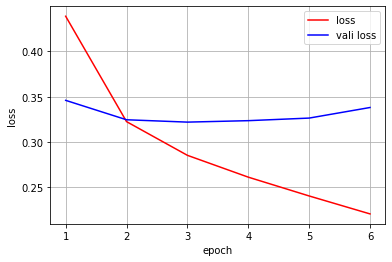

In [33]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='vali loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.show()

---

##학습된 임베딩 레이어 분석

In [34]:
embed = model.layers[0]
weight = embed.get_weights()[0]
print(weight.shape)

(10000, 1000)


In [35]:
path = '/content/drive/MyDrive/pic/ex/word2vec.txt'
f = open(path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


word2vector를 사용하여 최고와 연관성 있는 단어를 출력해보았다.

상당히 유사한 의미를 가지고 있는 단어들이 나오는걸 확인할 수 있다.

In [36]:
word = Word2VecKeyedVectors.load_word2vec_format(path, binary=False)
vector = word['최고']
word.similar_by_word("최고")

[('습니당', 0.6703523397445679),
 ('올려야', 0.6687526702880859),
 ('수작', 0.6665787696838379),
 ('이제서야', 0.666234016418457),
 ('살아가', 0.6603032350540161),
 ('담백', 0.650671124458313),
 ('울컥', 0.6478133201599121),
 ('명화', 0.6475306153297424),
 ('재밌', 0.646729052066803),
 ('명작', 0.646550178527832)]

---

##실제로 리뷰 문장을 분석해보자

In [42]:
from gensim import models

def sentiment_predict(model, new_sentence):
  tokenizer = Mecab()
  tokenizer1 = Tokenizer()
  new_sentence = tokenizer.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in new_sentence] # 정수 인코딩
  pad_new = pad_sequences([encoded], value=word_to_index["<PAD>"], padding='pre', maxlen = maxlen) # 패딩
  score = float(model.predict(pad_new)) # 예측
  print(new_sentence,encoded,score)
  if(score > 0.5):
    print("{:.2f}% 긍정!\n".format(score * 100))
  else:
    print("{:.2f}% 부정!\n".format((1 - score) * 100))

In [74]:
sentiment_predict(model2,'노잼 --')

['노', '잼', '--'] [1, 269, 102, 2298] 0.46640411019325256
53.36% 부정!



In [80]:
sentiment_predict(model2,'감동적 ㅠㅠ')

['감동', '적', 'ㅠㅠ'] [1, 80, 26, 167] 0.4057157039642334
59.43% 부정!



In [81]:
sentiment_predict(model2,'이게 영화냐?')

['이게', '영화', '냐', '?'] [1, 154, 5, 105, 18] 0.4626069962978363
53.74% 부정!



---

##한국어 Word2Vec 임베딩

https://github.com/Kyubyong/wordvectors 사이트에서 한국어를 다운로드하여 모델 성능을 개선 

In [37]:
%cd "/content/drive/MyDrive/pic/ex"
!unzip "ko.zip"

/content/drive/MyDrive/pic/ex
Archive:  ko.zip
  inflating: ko.bin                  
  inflating: ko.tsv                  


In [52]:
path = '/content/drive/MyDrive/pic/ex/ko.bin'

word2vec = Word2Vec.load(path)
wordvec = word2vec['최고']
wordvec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-1.0152713 , -0.06063395,  2.1013865 , -0.53053313,  0.48102048,
        0.4177825 ,  0.49066627, -1.7467129 , -0.23554218, -0.7802825 ,
        0.25205642, -0.7281079 , -0.5708346 ,  0.21512164,  0.37895873,
       -0.19593605,  1.4408356 , -0.26080552, -0.07197228,  0.9805705 ,
       -0.8030876 ,  0.25228414,  0.9123625 ,  1.2411838 ,  0.13870052,
        1.7325059 , -1.5783826 , -0.01432369,  0.30926976, -1.1689153 ,
       -3.1362064 , -0.31123805, -1.9127095 ,  0.88544   , -1.2766863 ,
       -0.8333593 , -0.11097712, -0.12470332, -2.0818698 , -0.9692228 ,
        0.02903495,  0.15543027, -0.6413738 , -1.7524667 ,  0.00903614,
        0.88036394,  1.8842533 ,  0.88254404,  0.30437934,  0.6343431 ,
        0.09495168, -1.4400343 ,  0.3601637 ,  1.134219  ,  2.3110375 ,
       -0.96069014,  1.9474247 , -1.1871786 , -1.5479655 , -0.50269765,
       -0.77446526, -1.9552984 ,  1.2855368 ,  3.6265228 , -1.9013956 ,
       -2.6395707 , -0.6660882 , -0.56544715,  1.7273039 , -1.93

최고를 다시 출력해 보았을때, 직접 만든 모델하고는 확실한 차이점을 보인다.

훨씬 학습이 잘되어있는걸로 보인다.

In [53]:
word2vec.similar_by_word("최고")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('최대', 0.5721614360809326),
 ('최강', 0.5064552426338196),
 ('유일한', 0.46688494086265564),
 ('일류', 0.46184951066970825),
 ('최악', 0.4529539942741394),
 ('최연소', 0.45037323236465454),
 ('랭킹', 0.4485436677932739),
 ('제일의', 0.44647401571273804),
 ('최초', 0.44505739212036133),
 ('최상', 0.4345606565475464)]

In [54]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


---

##위에 만든 임베딩으로 모델 학습

In [56]:
from keras.initializers import Constant

model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim,  embeddings_initializer = Constant(embedding_matrix), 
                                 input_length=maxlen, trainable=True))
model1.add(keras.layers.LSTM(128, dropout=0.7))
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_5 (LSTM)               (None, 128)               168448    
                                                                 
 dense_10 (Dense)            (None, 8)                 1032      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [57]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
              
hist = model1.fit(partial_x_train, partial_y_train, epochs = 20, batch_size = 128, validation_data=(x_val, y_val), verbose=1,
                 callbacks=[early_stopping, model_check])

Epoch 1/20
982/986 [============================>.] - ETA: 0s - loss: 0.6917 - accuracy: 0.5087
Epoch 1: val_accuracy did not improve from 0.86440
986/986 [==============================] - 10s 8ms/step - loss: 0.6917 - accuracy: 0.5088 - val_loss: 0.6848 - val_accuracy: 0.5185
Epoch 2/20
981/986 [============================>.] - ETA: 0s - loss: 0.5618 - accuracy: 0.7013
Epoch 2: val_accuracy did not improve from 0.86440
986/986 [==============================] - 8s 8ms/step - loss: 0.5616 - accuracy: 0.7014 - val_loss: 0.4780 - val_accuracy: 0.7833
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.7796
Epoch 3: val_accuracy did not improve from 0.86440
986/986 [==============================] - 8s 8ms/step - loss: 0.4635 - accuracy: 0.7796 - val_loss: 0.4259 - val_accuracy: 0.8086
Epoch 4/20
986/986 [==============================] - ETA: 0s - loss: 0.4243 - accuracy: 0.8028
Epoch 4: val_accuracy did not improve from 0.86440
986/986 [=========

---

##결과 확인

결과과 직접 정의한 LSTM보다 높은 결과를 나타내는것을 볼 수 있다.

In [58]:
num1 = model1.evaluate(X_test,  y_test, verbose=2)
print(num1)

1537/1537 - 4s - loss: 0.3318 - accuracy: 0.8644 - 4s/epoch - 2ms/step
[0.3318071961402893, 0.8643530011177063]


---

##학습 결과 시각화

학습 또한 길게 잘 이루어진것으로 보여진다.

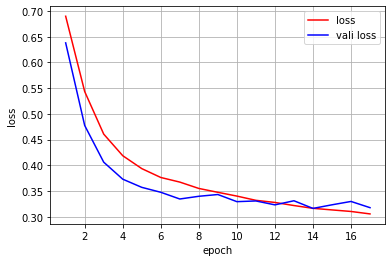

In [29]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='vali loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.show()

---

##실제로 리뷰 문장을 분석해보자

In [61]:
sentiment_predict(model1,'감동적 ㅠㅠ')

['감동', '적', 'ㅠㅠ'] [1, 80, 26, 167] 0.591117799282074
59.11% 긍정!



In [62]:
sentiment_predict(model1,'최고에요!')

['최고', '요', '!'] [1, 56, 203, 14] 0.9531180262565613
95.31% 긍정!



In [63]:
sentiment_predict(model1,'노잼 --')

['노', '잼', '--'] [1, 269, 102, 2298] 0.20790937542915344
79.21% 부정!



In [82]:
sentiment_predict(model1,'이게 영화냐?')

['이게', '영화', '냐', '?'] [1, 154, 5, 105, 18] 0.3371959328651428
66.28% 부정!



---

##마무리

이번 노드에서는 세가지 모델을 사용해보았다.
1. Covn1D
2. GlobalMaxPooling1D 
3. LSTM

성능 면에서는 근소한 차이로 LSTM 점수가 조금 더 높아 LSTM 하이퍼 파라미터를 바꾸어서 

진행한 결과 정확도가 85퍼를 넘겼다.

하지만 실제로 문장을 넣어서 긍정인지, 부정인지 평가해본 결과를 처참했다.

위에 결과를 보면 긍정적인 영화도 부정으로 평가하고 

무엇하나 확실하게 평가한것이 없어 보인다.

반면, pre_trained된 모델을 사용했을 경우 정확도도 높아졌을뿐더러

문장을 읽고 감정을 분석해주는 능력도 훨씬 뛰어난걸 확인할 수 있다.

연관 단어도 차이를 보인다.

직접 구현한 모델에 최고를 넣으면 담백, 울컥, 명작과 같은 추상적인 의미로 유사한 단어가 나오고

pre_tained된 모델에 최고를 넣으면 최강, 최대, 유일과 같은 사전적으로 최고와 유사한 단어들이 나오는 점이 흥미로웠다.

이러한 점을 볼때, 학습된 모델보다 성능을 좋은 모델을 만드는 것을 향후과제로 생각하는 것도 나쁘지 않아 보인다.

---

##참고자료
https://github.com/BYK82/AIFFEL/blob/main/Exploration_GN4/%5BE_09%5D.ipynb